This notebook looks at the research in the paper [A Fine is a Price](https://rady.ucsd.edu/faculty/directory/gneezy/pub/docs/fine.pdf) by Uri Gneezy and Aldo Rustichini.

In this study they experiment on 10 private day-care centres (2 were removed because of incomplete data) in Haifa, Isreal from January to June 1998.
Initially there are no penalties for late pickup.
From the fifth week to the sixteenth week in the 6 test centres a fine of NIS 10 is charged for pickup at least 10 minutes late, added to their fee of NIS 1400 paid each month.
From the seventeenth to the twentieth the fine is removed with no explanation in the test group.

The goal of the study is to understand the impact of this fee on pickups.

In [3]:
suppressPackageStartupMessages(library(rstanarm))
suppressPackageStartupMessages(library(ggformula))
library(tibble)
suppressPackageStartupMessages(library(glue))
suppressPackageStartupMessages(library(dplyr))
library(stringr)
library(tidyr)

In [27]:
# Set the maximum number of columns and rows to display
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
# Set the default plot size
options(repr.plot.width=18, repr.plot.height=12)

The data is reproduced from Table 1 in the paper

> The first column reports the number  of  the  day-care  centers  in  our  study  (the  first  six  are  the  test  group,where a fine was introduced, and the last four are the control group). Thesecond column reports the total number of children in the center. The othercolumns report the number of times per week that parents came late (eachoccurrence of a delay is a separate item). For example, in week 4 day-care center number 3 had nine cases of late-arriving parents.

In [8]:
df_raw <- readr::read_csv('data/gneezy_fine_price.csv')


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  condition = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [18]:
df_raw

condition,centre_id,children,1,2,3,4,5,6,7,⋯,11,12,13,14,15,16,17,18,19,20
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Test,1,37,8,8,7,6,8,9,9,⋯,15,13,14,16,14,15,16,13,15,17
Test,2,35,6,7,3,5,2,11,14,⋯,10,14,14,16,12,17,14,10,14,15
Test,3,35,8,9,8,9,3,5,15,⋯,20,18,25,22,27,19,20,23,23,22
Test,4,34,10,3,14,9,6,24,8,⋯,25,18,23,22,24,17,15,23,25,18
Test,5,33,13,12,9,13,15,10,27,⋯,24,32,29,29,26,31,26,35,29,28
Test,6,28,5,8,7,5,5,9,12,⋯,14,13,10,15,14,16,6,12,17,13
Control,7,35,7,10,12,6,4,13,7,⋯,3,5,6,13,7,4,7,10,4,6
Control,8,34,12,9,14,18,10,11,6,⋯,7,12,9,9,17,8,5,11,8,13
Control,9,34,3,4,9,3,3,5,9,⋯,6,6,9,4,9,2,3,8,3,5


In [43]:
df <- df_raw %>%
pivot_longer("1":"20", names_to="week", values_to="late") %>%
mutate(centre_id = as.factor(centre_id),
       week = as.integer(week),
       fine = (condition == 'Test') & (week >= 5) & (week <= 16),
       after_fine = (condition == 'Test') & (week >= 17),
       p = late / (children * 5) # Assume all children have 5 days of care; not clear in article
      )

df %>% head()

condition,centre_id,children,week,late,fine,after_fine,p
<chr>,<fct>,<dbl>,<int>,<dbl>,<lgl>,<lgl>,<dbl>
Test,1,37,1,8,FALSE,FALSE,0.04324324
Test,1,37,2,8,FALSE,FALSE,0.04324324
Test,1,37,3,7,FALSE,FALSE,0.03783784
Test,1,37,4,6,FALSE,FALSE,0.03243243
Test,1,37,5,8,TRUE,FALSE,0.04324324
Test,1,37,6,9,TRUE,FALSE,0.04864865


Visually the results are quite clear - it often takes a week or two to see any impact, but then the uplift on centres that impose a fine is dramatic, and the after the fine is removed the condition continues.

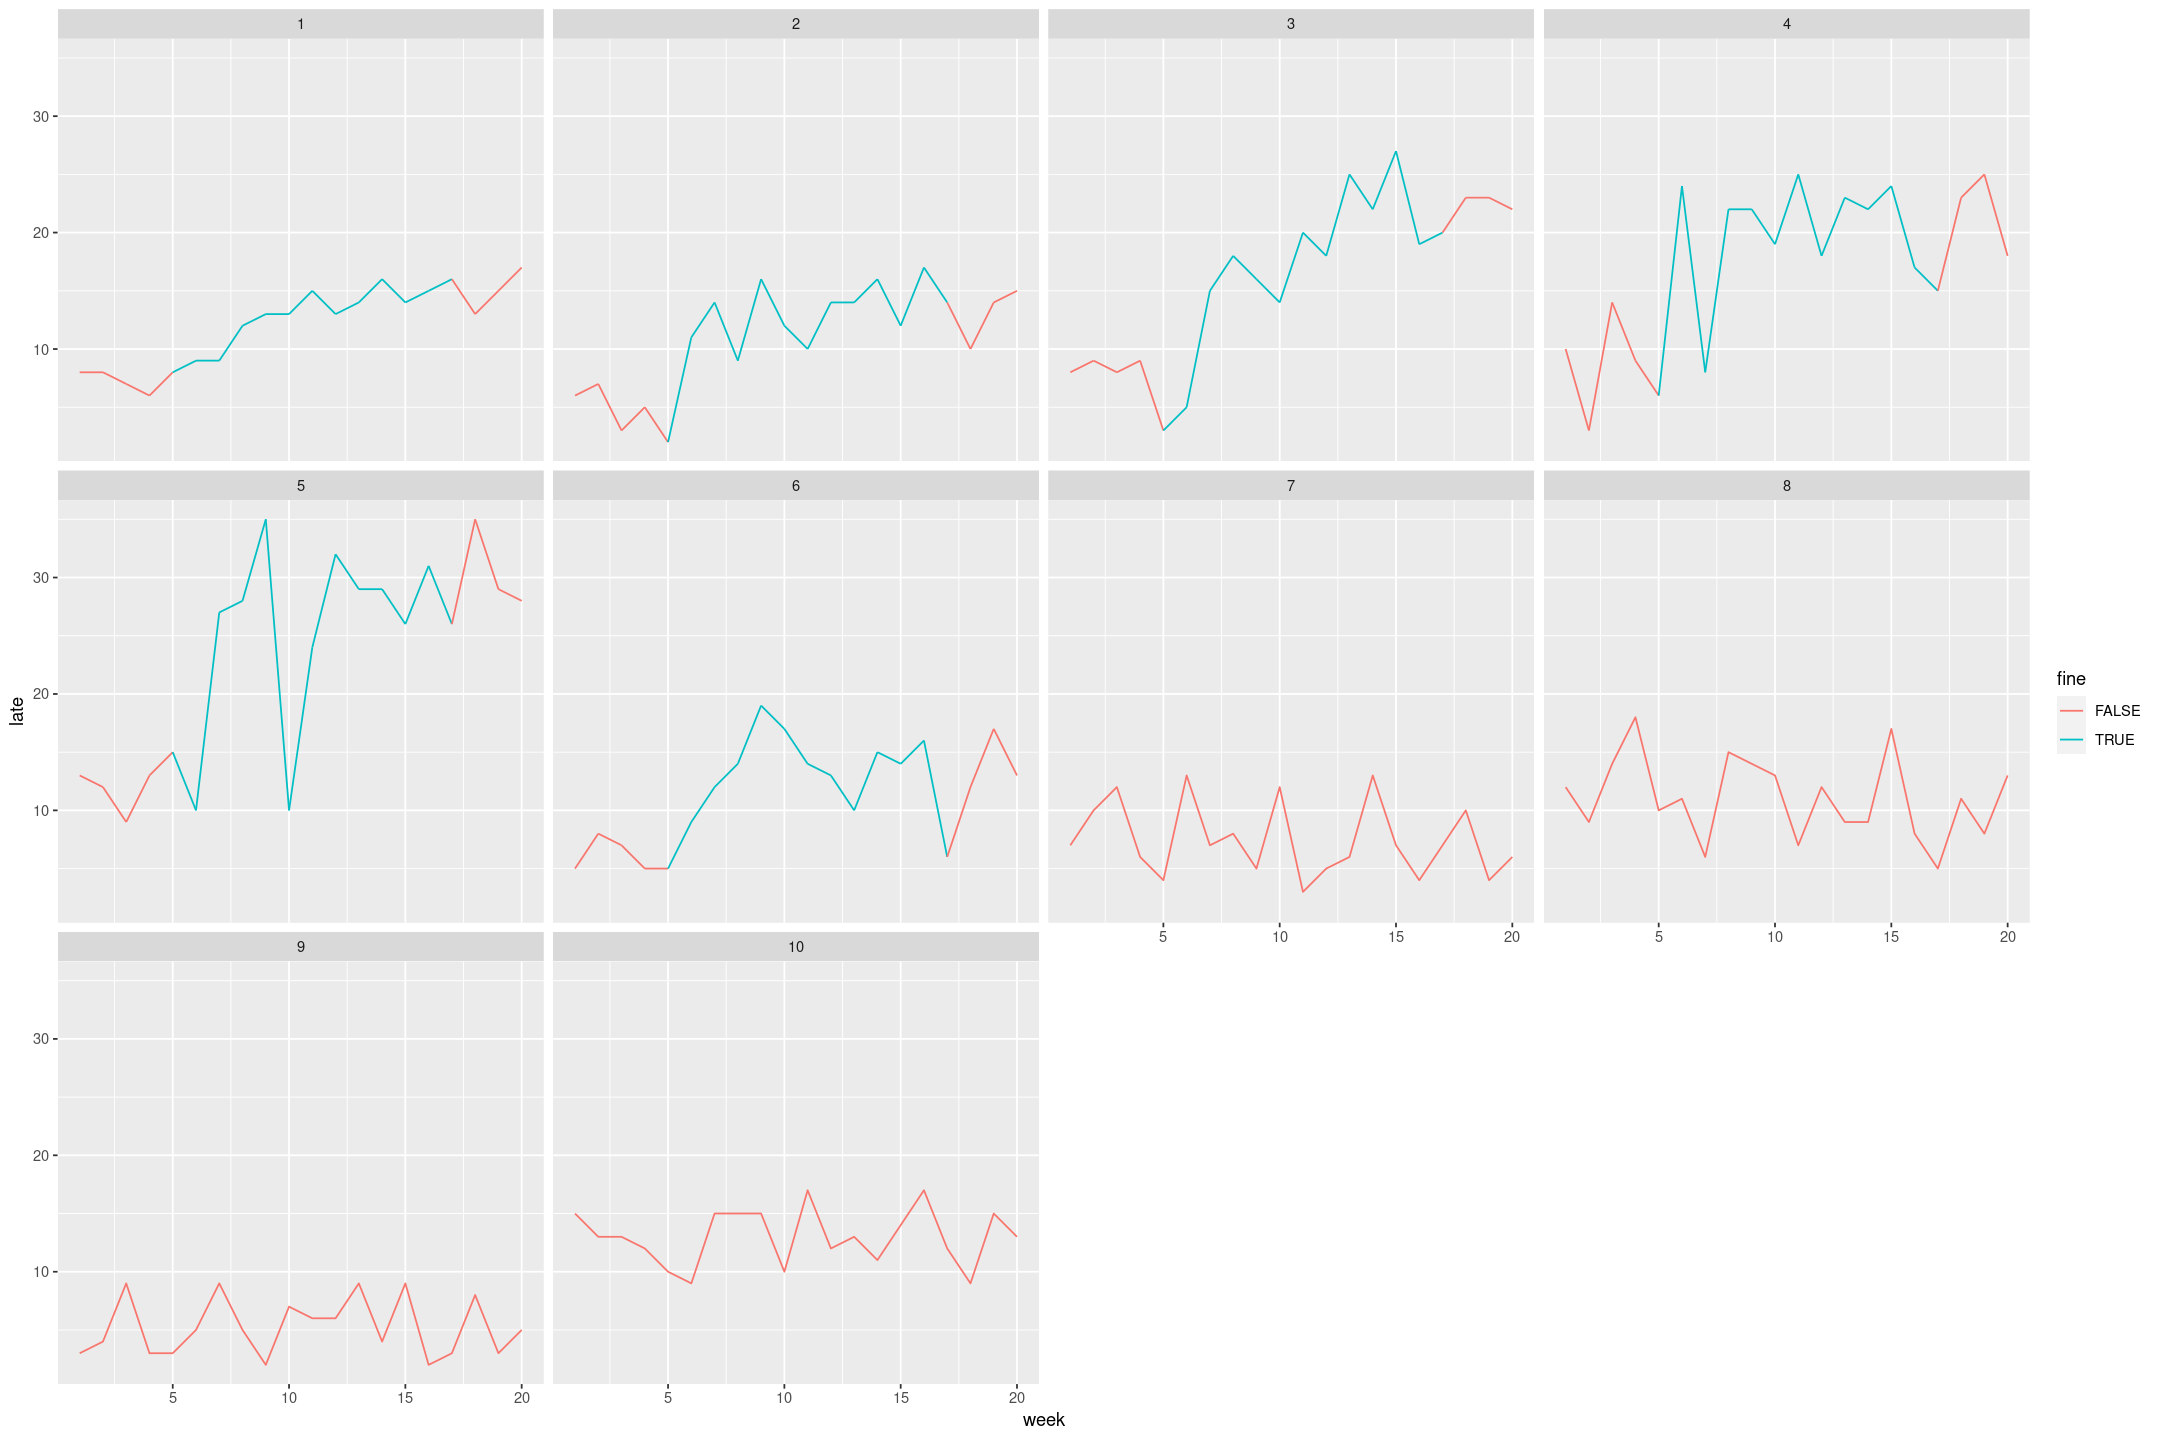

In [35]:
df %>% 
gf_line(late ~ week | centre_id, col=~fine, group=~centre_id)

# Linear Modelling

In [44]:
linear_fit <- stan_glm(late ~ centre_id + as.factor(week) + fine + after_fine, data=df, refresh=0)

The centres have quite different numbers of children-absent days; as you would expect.
It's not immedately obvious whether the test and experimental group are distinguishable.

The weeks 5, 6 and 17 appear to have a lower numbers of children absences.

However the largest factors are, by far, whether a fine was imposed.
After taking into account all the other factors the fine increases the number of late pickups by 9 per week (s.d. 1) and after the fine it's 12 per week.

Given that the average befor intervention was between 3 and 15 this is a very significant increase.

Note that we're using 31 parameters on 200 data points, so there is serious risk of overfitting here.

In [45]:
print(linear_fit)

stan_glm
 family:       gaussian [identity]
 formula:      late ~ centre_id + as.factor(week) + fine + after_fine
 observations: 200
 predictors:   31
------
                  Median MAD_SD
(Intercept)        4.7    1.5  
centre_id2        -1.0    1.2  
centre_id3         4.2    1.2  
centre_id4         5.3    1.3  
centre_id5        11.0    1.2  
centre_id6        -0.5    1.2  
centre_id7         3.3    1.6  
centre_id8         6.9    1.6  
centre_id9         1.1    1.6  
centre_id10        8.8    1.6  
as.factor(week)2  -0.3    1.7  
as.factor(week)3   1.0    1.7  
as.factor(week)4   0.0    1.7  
as.factor(week)5  -7.5    1.9  
as.factor(week)6  -3.4    1.9  
as.factor(week)7  -1.8    1.9  
as.factor(week)8   0.6    1.9  
as.factor(week)9   1.7    1.9  
as.factor(week)10 -1.3    1.9  
as.factor(week)11  0.1    2.0  
as.factor(week)12  0.3    1.9  
as.factor(week)13  1.2    1.9  
as.factor(week)14  1.7    1.9  
as.factor(week)15  2.4    1.9  
as.factor(week)16  0.6    1.9  
as.factor(

In [51]:
loo_linear <- loo(linear_fit)
loo_linear


Computed from 4000 by 200 log-likelihood matrix

         Estimate   SE
elpd_loo   -569.2 12.6
p_loo        30.4  3.6
looic      1138.3 25.1
------
Monte Carlo SE of elpd_loo is 0.2.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     196   98.0%   418       
 (0.5, 0.7]   (ok)         4    2.0%   104       
   (0.7, 1]   (bad)        0    0.0%   <NA>      
   (1, Inf)   (very bad)   0    0.0%   <NA>      

All Pareto k estimates are ok (k < 0.7).
See help('pareto-k-diagnostic') for details.

The residuals look a little larger at high values than at low - I suspect a logarithmic or proportional model would do better.

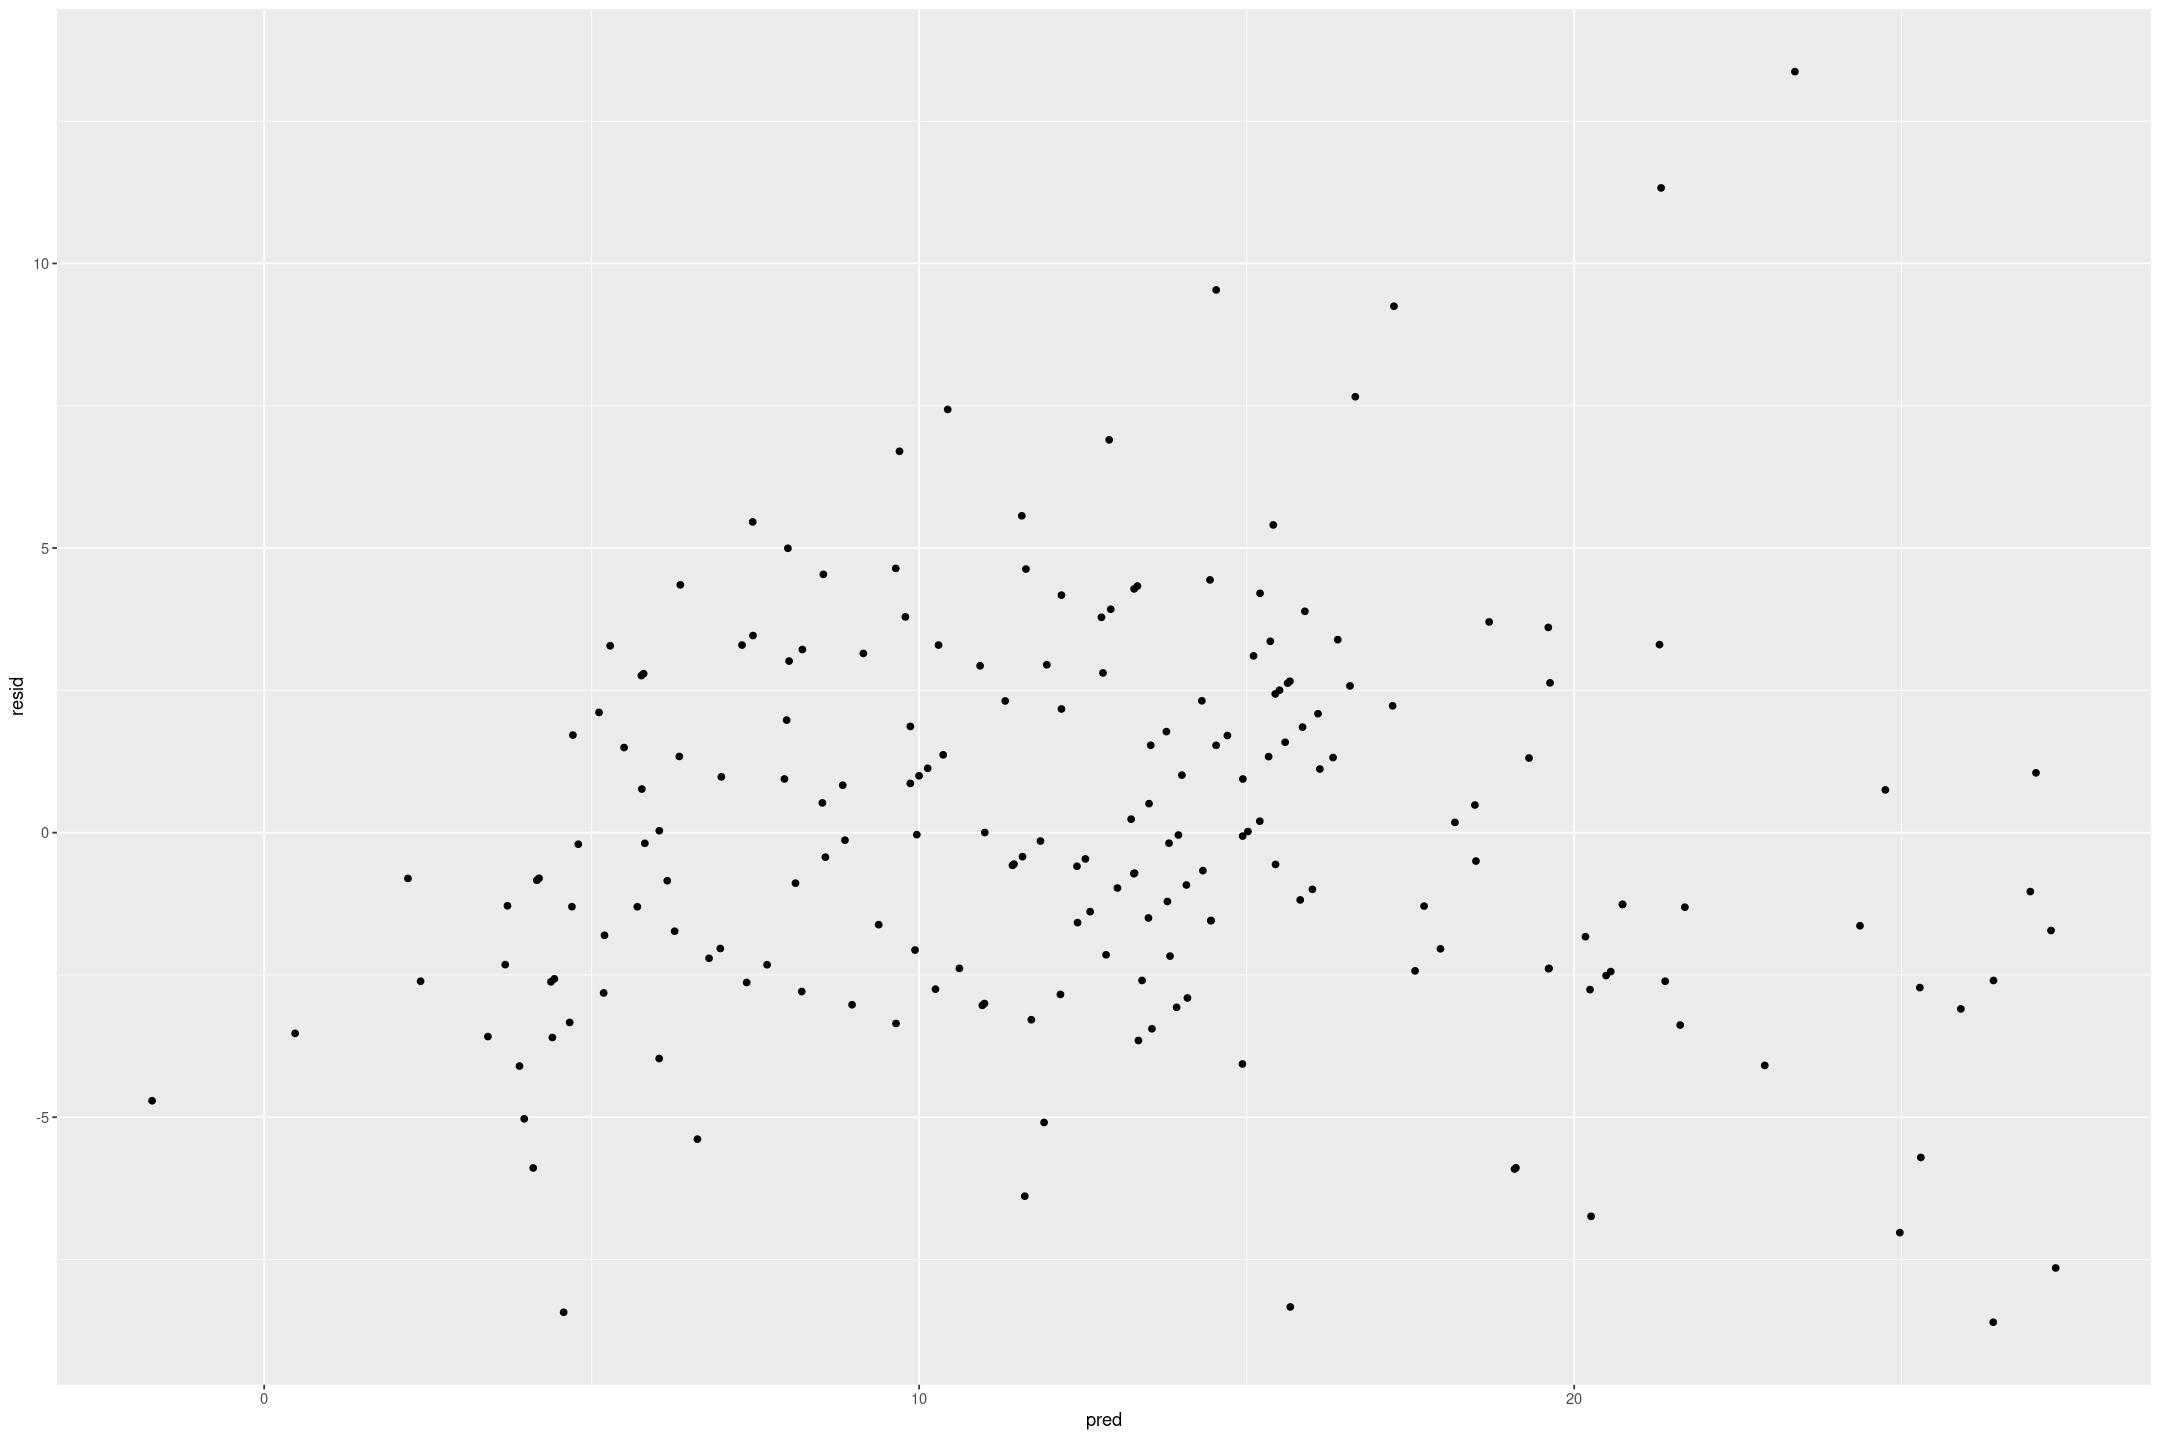

In [48]:
df %>%
modelr::add_predictions(linear_fit) %>%
mutate(resid = pred - late) %>%
gf_point(resid ~ pred)

The fits look pretty good, but we can see especially in centres 3, 4, 5 and 6 the initial fit is a little loose.

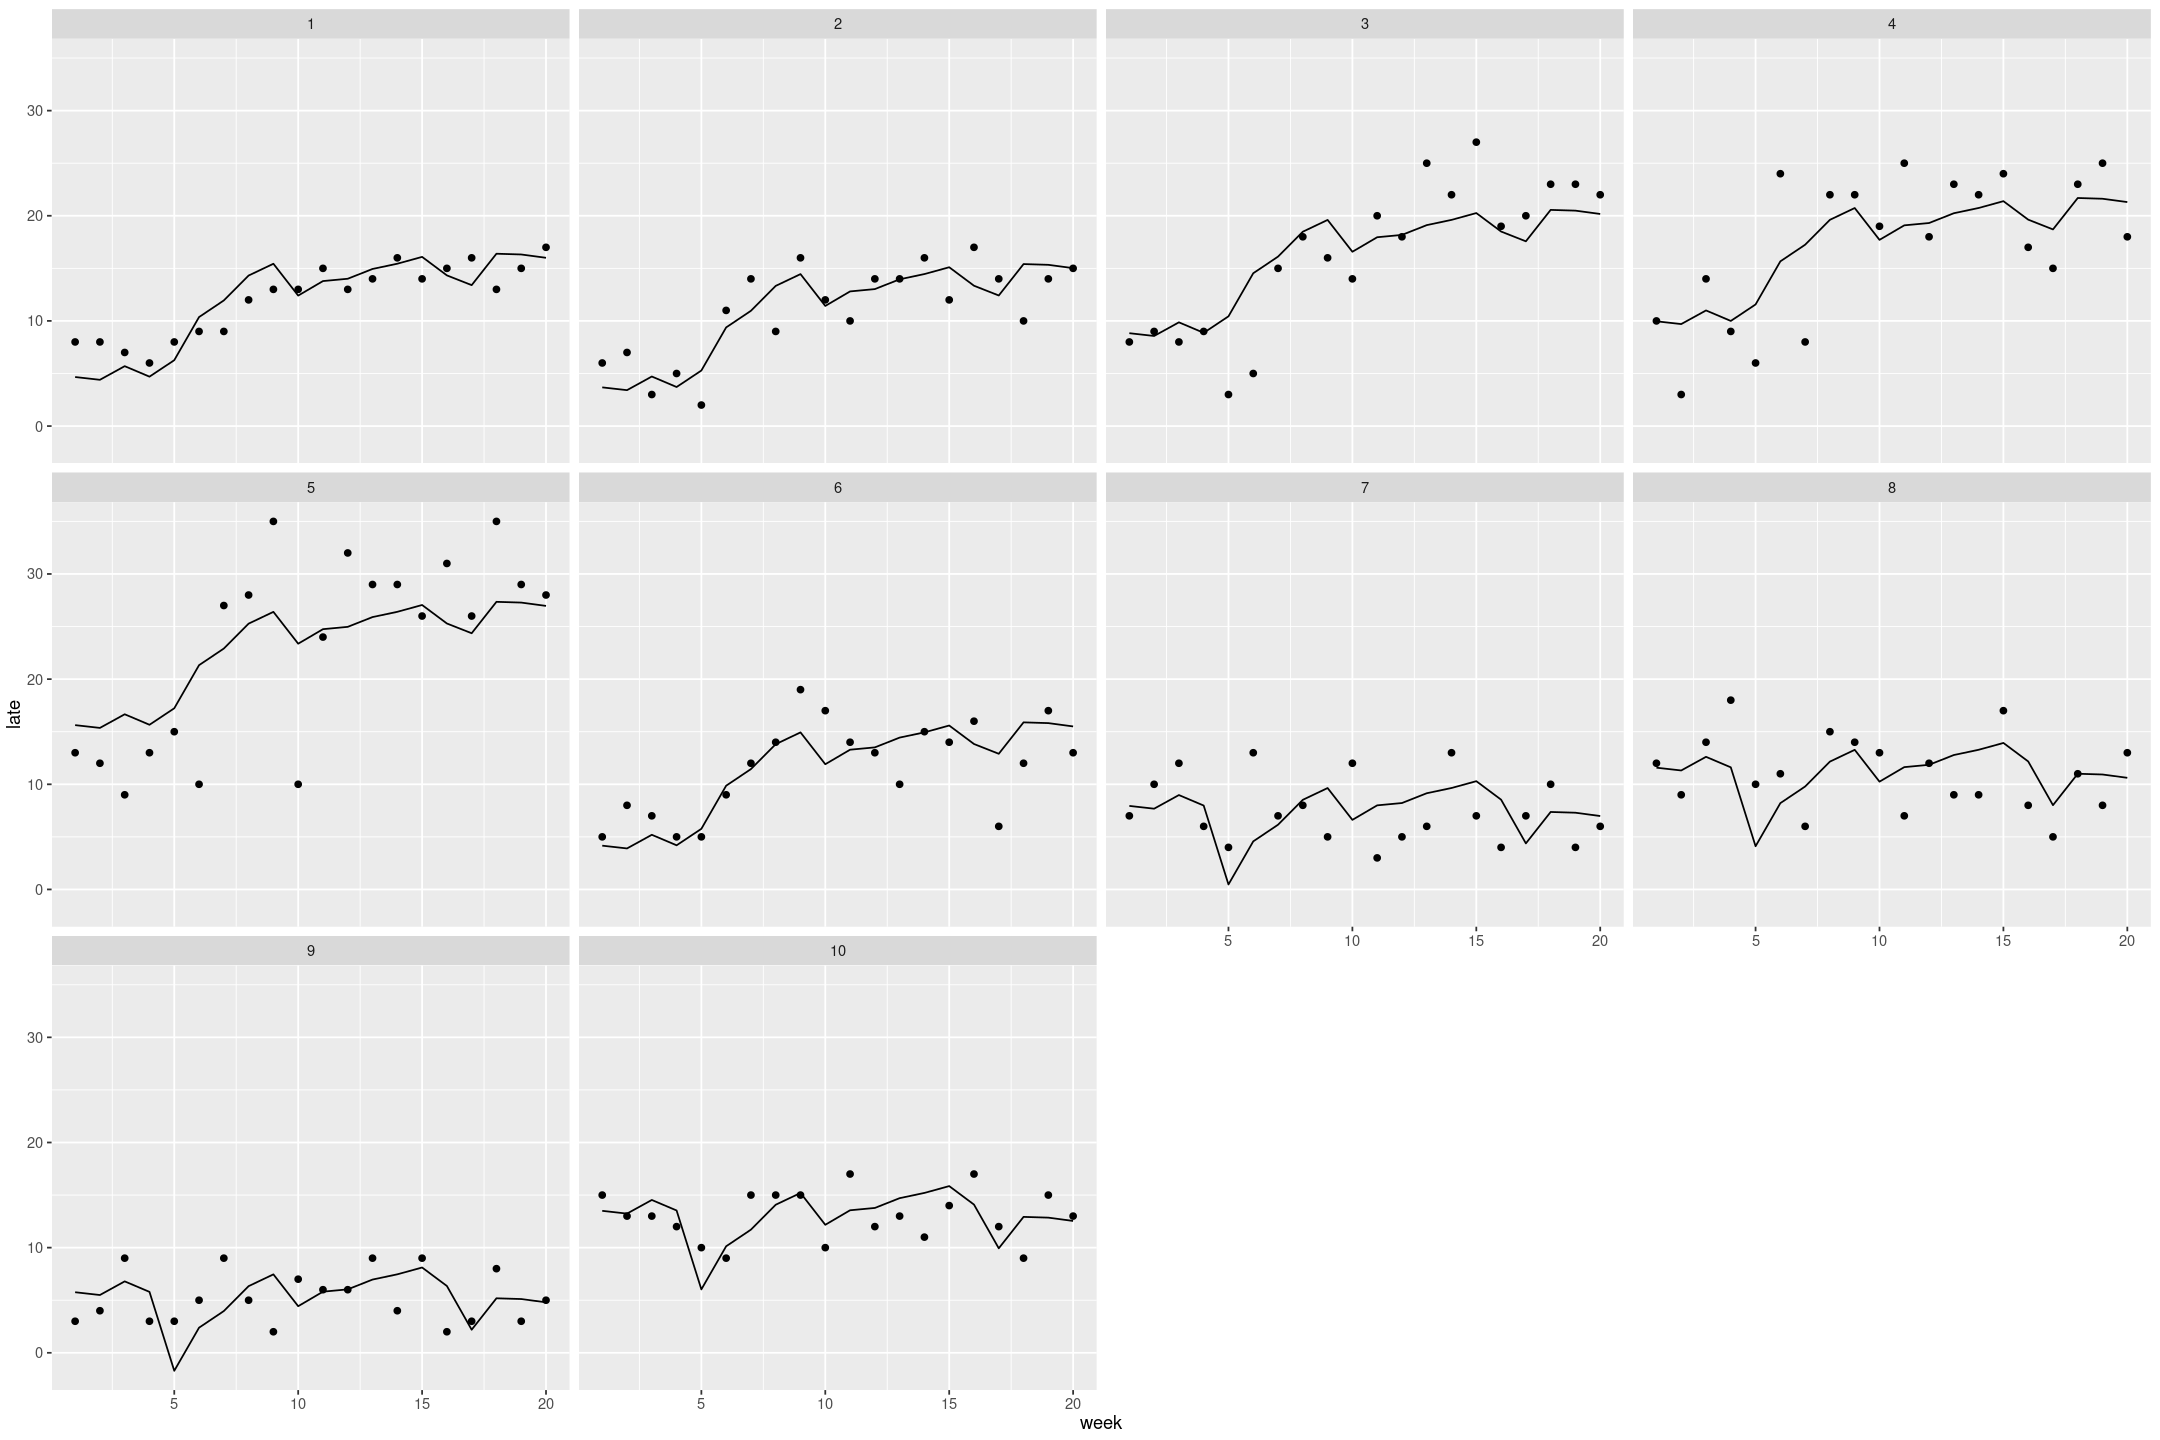

In [49]:
df %>% 
modelr::add_predictions(linear_fit) %>%
gf_point(late ~ week | centre_id) %>%
gf_line(pred ~ week | centre_id)

## Adding interactions

Visually it appears there's a couple of weeks for the effect to burn in.
Let's see if we can capture this with an interaction.

In [52]:
linear_interact_fit <- stan_glm(late ~ centre_id + as.factor(week) * fine + after_fine, data=df, refresh=0)

Warning message in center_x(x, sparse):
“Dropped empty interaction levels: as.factor(week)2:fineTRUE, as.factor(week)3:fineTRUE, as.factor(week)4:fineTRUE, as.factor(week)17:fineTRUE, as.factor(week)18:fineTRUE, as.factor(week)19:fineTRUE, as.factor(week)20:fineTRUE”
Warning message:
“There were 8 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 1000 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 15. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 5.75, indicating chains have not mixed.
Running the c

In [53]:
linear_interact_fit

stan_glm
 family:       gaussian [identity]
 formula:      late ~ centre_id + as.factor(week) * fine + after_fine
 observations: 200
 predictors:   43
------
                           Median MAD_SD
(Intercept)                 -25.2   27.0
centre_id2                  -20.5   14.9
centre_id3                  -31.8   62.3
centre_id4                   15.3   36.1
centre_id5                  -26.8   29.8
centre_id6                   37.4   39.3
centre_id7                  -28.1   98.4
centre_id8                  -29.9   19.4
centre_id9                   61.1   23.3
centre_id10                  40.6   30.7
as.factor(week)2             72.2   81.7
as.factor(week)3             14.2   86.2
as.factor(week)4             29.7   40.6
as.factor(week)5            -65.5   25.1
as.factor(week)6             20.6    3.2
as.factor(week)7            -24.3  129.5
as.factor(week)8             30.3   90.4
as.factor(week)9             73.4   84.4
as.factor(week)10           -95.9   74.5
as.factor(week)11     

In [59]:
1-.8

[1] 0.2

In [64]:
qnorm(1-(1-0.95)/2) + qnorm(1-(1-0.80))

[1] 2.801585

[1] 0.8416212